In [2]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from scipy.optimize import leastsq
from scipy.stats import mannwhitneyu, ttest_ind, shapiro
import pandas as pd
import seaborn as sns

color_palette = sns.color_palette("colorblind")
sns.set_theme(palette=color_palette, font="Arial", font_scale=1.0, style="white")

In [3]:
#styles for error and markers in sns.lineplot

thin_custom_lw = 1.2
custom_lw = thin_custom_lw/0.65

filled_marker_style = dict(marker='o',  markersize=5,
                           color='k',
                           markerfacecolor='w',
                           markeredgecolor='k',
                          markeredgewidth=thin_custom_lw)

filled_marker_style_white = dict(marker='o',  markersize=5,
                           color='w',
                           markerfacecolor='w',
                           markeredgecolor='w',
                          markeredgewidth=custom_lw)
######################

error_style_white = {"capsize": 4.4, 
                "ecolor": "w",
               "barsabove":False, 
               "elinewidth":custom_lw, 
               "capthick":custom_lw,
                    "zorder": 8}

error_style = {"capsize": 4, 
                "ecolor": "k",
                "barsabove":False, 
                "elinewidth":thin_custom_lw, 
                "capthick":thin_custom_lw,
                "zorder": 9}

# number of iterations and seed for bootstrapping during calculation of confidence intervals
n_boot = 10000
seed = 10

In [4]:
def logistic4(x, A, B, C, D):
    """4PL logistic equation."""
    return ((A-D)/(1.0+((x/C)**B))) + D

def residuals(p, y, x):
    """Deviations of data from fitted 4PL curve"""
    A,B,C,D = p
    err = y-logistic4(x, A, B, C, D)
    return err

def peval(x, p):
    """Evaluated value at x with current parameters."""
    A,B,C,D = p
    return logistic4(x, A, B, C, D)
    
def get_x(y, p, dilution):
    A = p[0]
    B = p[1]
    C = p[2]
    D = p[3]
    return (C*((((A-D)/(y-D))-1)**(1/B)))*dilution


Aldosterone ELISA

In [34]:
raw_data = pd.read_csv("Cacna1h_KO_aldo.csv", decimal=",", sep=";")

raw_data["OD"] = raw_data.OD.astype("float64")

In [35]:
raw_data

,Date,Animal,Group,dilution_factor,Cal0,Cal20,Cal80,Cal200,Cal500,Cal1000,Neg,Pos,OD
0,21.11.2023,18792,TTA-P2 + Isradipine,1,1.841,1.503,0.901,0.451,0.268,0.184,0.993,0.299,1.684
1,21.11.2023,18792,Control,1,1.841,1.503,0.901,0.451,0.268,0.184,0.993,0.299,0.984
2,21.11.2023,18793,TTA-P2 + Isradipine,1,1.841,1.503,0.901,0.451,0.268,0.184,0.993,0.299,1.524
3,21.11.2023,18793,Control,1,1.841,1.503,0.901,0.451,0.268,0.184,0.993,0.299,0.772
4,22.11.2023,18794,TTA-P2 + Isradipine,1,1.841,1.503,0.901,0.451,0.268,0.184,0.993,0.299,1.566
5,22.11.2023,18794,Control,1,1.841,1.503,0.901,0.451,0.268,0.184,0.993,0.299,0.447
6,22.11.2023,18865,TTA-P2 + Isradipine,1,1.841,1.503,0.901,0.451,0.268,0.184,0.993,0.299,1.596
7,22.11.2023,18865,Control,1,1.841,1.503,0.901,0.451,0.268,0.184,0.993,0.299,0.816
8,22.11.2023,18866,TTA-P2 + Isradipine,1,1.841,1.503,0.901,0.451,0.268,0.184,0.993,0.299,1.152
9,22.11.2023,18866,Control,1,1.841,1.503,0.901,0.451,0.268,0.184,0.993,0.299,1.480


In [36]:
cal_conc = [0, 20, 80, 200, 500, 1000]
calibration = {}

Groups = raw_data.Group.unique()
raw_data["Concentration"] = 0

# Initial guess for parameters
p0 = [0, -1.5, 100, 1]

# Calibrate and calculate concentrations
raw_data["Calibration"] = raw_data.apply(lambda row: leastsq(residuals, p0, args=([row.Cal0, row.Cal20, row.Cal80, row.Cal200, row.Cal500, row.Cal1000], cal_conc)), axis=1)
raw_data["Concentration"] = raw_data.apply(lambda row: get_x(row.OD, row.Calibration[0], row.dilution_factor), axis=1)
raw_data["Neg_Concentration"] = raw_data.apply(lambda row: get_x(row.Neg, row.Calibration[0], 1), axis=1)
raw_data["Pos_Concentration"] = raw_data.apply(lambda row: get_x(row.Pos, row.Calibration[0], 1), axis=1)


raw_data.loc[raw_data.OD>2.142, "Concentration"] = 0

data = raw_data.groupby(["Animal", "Group"]).agg({
                       'Concentration': 'mean'}).reset_index()


C:\Users\dinhha\AppData\Local\Temp\ipykernel_22340\2753156243.py:3: RuntimeWarning: divide by zero encountered in power
  return ((A-D)/(1.0+((x/C)**B))) + D


In [37]:
data

,Animal,Group,Concentration
0,18792,Control,65.644854
1,18792,TTA-P2 + Isradipine,9.844939
2,18793,Control,99.293026
3,18793,TTA-P2 + Isradipine,19.351928
4,18794,Control,218.351216
5,18794,TTA-P2 + Isradipine,16.783331
6,18865,Control,90.893205
7,18865,TTA-P2 + Isradipine,14.988403
8,18866,Control,22.127998
9,18866,TTA-P2 + Isradipine,47.380586


C:\Users\dinhha\AppData\Local\Temp\ipykernel_22340\2753156243.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  return ((A-D)/(1.0+((x/C)**B))) + D
C:\Users\dinhha\AppData\Local\Temp\ipykernel_22340\2753156243.py:3: RuntimeWarning: divide by zero encountered in power
  return ((A-D)/(1.0+((x/C)**B))) + D


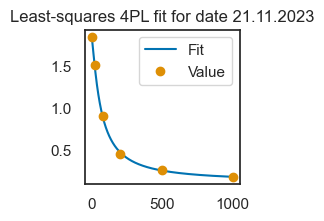

C:\Users\dinhha\AppData\Local\Temp\ipykernel_22340\2753156243.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  return ((A-D)/(1.0+((x/C)**B))) + D
C:\Users\dinhha\AppData\Local\Temp\ipykernel_22340\2753156243.py:3: RuntimeWarning: divide by zero encountered in power
  return ((A-D)/(1.0+((x/C)**B))) + D


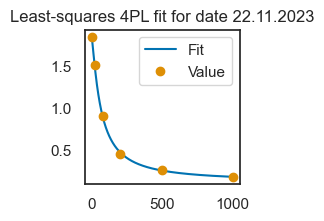

In [38]:
for date in raw_data.Date.unique():
    animal = raw_data[raw_data.Date == date].Animal.unique()[0]

    data_animal = raw_data[raw_data.Animal == animal].reset_index()
    cal_data = [data_animal.Cal0[0], data_animal.Cal20[0], data_animal.Cal80[0], data_animal.Cal200[0], data_animal.Cal500[0], data_animal.Cal1000[0]]

    
    x = cal_conc
    y_meas = cal_data

    # Initial guess for parameters
    p0 = [0, -1, 100, 1]

    # Fit equation using least squares optimization
    plsq = leastsq(residuals, p0, args=(y_meas, x))

    # Plot results
    x_hr = range(0,1000,1)
    plt.figure(figsize=(2,2))
    plt.plot(x_hr,peval(x_hr,plsq[0]),x, y_meas,'o')
    plt.title(f'Least-squares 4PL fit for date {date}')
    plt.legend(['Fit', 'Value'], loc='upper right')
    #plt.semilogx()
    plt.show()
    
    calibration[animal] = plsq[0]


In [40]:
ctrl_values = data[data.Group=="Control"].Concentration.values
blocker_values = data[data.Group=="TTA-P2 + Isradipine"].Concentration.values

mannwhitneyu(ctrl_values, blocker_values)

MannwhitneyuResult(statistic=33.0, pvalue=0.015151515151515152)

Text(33.0, 0.5, 'Aldosterone (pg/ml)')

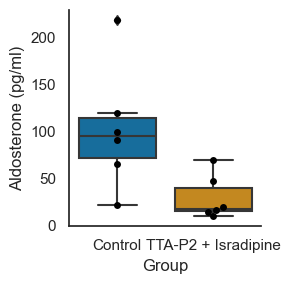

In [41]:
sns.catplot(data=data, x="Group", y="Concentration", kind="box", height=3, aspect=1)
sns.swarmplot(data=data, x="Group", y="Concentration", color="black")

sns.despine()
plt.ylabel("Aldosterone (pg/ml)")


In [42]:
data

,Animal,Group,Concentration
0,18792,Control,65.644854
1,18792,TTA-P2 + Isradipine,9.844939
2,18793,Control,99.293026
3,18793,TTA-P2 + Isradipine,19.351928
4,18794,Control,218.351216
5,18794,TTA-P2 + Isradipine,16.783331
6,18865,Control,90.893205
7,18865,TTA-P2 + Isradipine,14.988403
8,18866,Control,22.127998
9,18866,TTA-P2 + Isradipine,47.380586


C:\Users\dinhha\AppData\Local\Temp\ipykernel_22340\210955286.py:3: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  g = sns.swarmplot(data=data, x="Group", y="Concentration",


Text(0.5, -10.750000000000004, '')

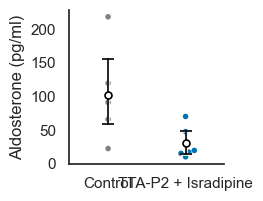

In [43]:
fig, g = plt.subplots(figsize=(2, 2))

g = sns.swarmplot(data=data, x="Group", y="Concentration",
                order= ["Control", "TTA-P2 + Isradipine"],
                 palette=["grey", color_palette[0]],
                 s=4, zorder=2, legend=False)

g = sns.lineplot(data=data, x="Group", y="Concentration", lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=3,  
             err_style="bars", 
             err_kws=error_style_white, 
             fillstyle="full", 
             **filled_marker_style_white)
             
    
g = sns.lineplot(data=data, x="Group", y="Concentration", lw=0,
             errorbar=("ci",95),
             n_boot=n_boot, seed=seed,
             zorder=10,  
             err_style="bars",
             err_kws=error_style,
             fillstyle="full", 
             **filled_marker_style)

g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)
plt.xlim([-0.5, 1.5])
plt.ylabel("Aldosterone (pg/ml)")
plt.xlabel("")